In [1]:
'''
Tom Egg
October 2, 2023
File to attempt analysis of tripeptoid enhanced sampling
'''

'\nTom Egg\nOctober 2, 2023\nFile to attempt analysis of tripeptoid enhanced sampling\n'

In [2]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

# Collective Variables and Free Energy

In [3]:
# COLVAR
file_path = '/scratch/tje3676/openmm-test/tri_output.csv'

# Attempt to load
df = pd.read_csv(file_path)

In [4]:
df.head()

,"#""Step""",s_phi,phi,s_psi,psi,Speed (ns/day)
0,10,-1.657290,-1.654603,3.121225,3.116265,0
1,20,-1.673392,-1.673385,3.134366,3.132362,121
2,30,-1.690975,-1.690452,-3.134282,-3.137795,122
3,40,-1.710936,-1.713041,-3.117337,-3.126837,123
4,50,-1.733894,-1.743573,-3.096902,-3.094630,123


## $\psi_1$ vs $\phi_1$

In [5]:
# Histogram variables
hist = np.zeros((20, 20))
x_edge = None
y_edge = None

# Histogram
hist, x_edges, y_edges = np.histogram2d(df['s_phi'], df['s_psi'], bins=[20, 20])
hist[hist == 0] = 1

In [6]:
# Transform to free energy:
def distribution_to_FE(hist):

    # Apply transformation
    hist = - (3000 * (8.314472 ** -3)) * np.log(hist)
    return hist / 4.214

# Convert histogram to FE histogram
hist = distribution_to_FE(hist)

# Shift histogram
min_value = np.min(hist)
hist = hist - min_value

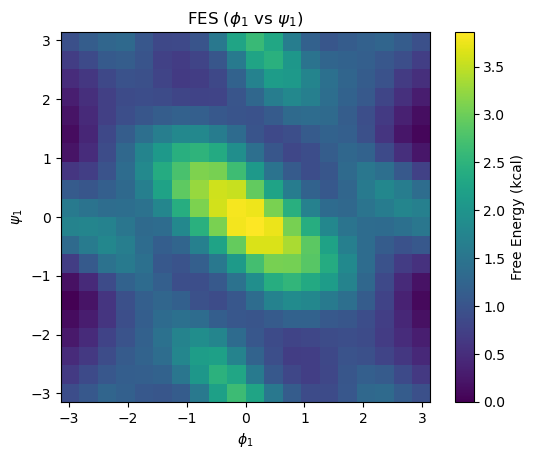

In [7]:
# Create a heatmap or 2D histogram plot
plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Free Energy (kcal)')
plt.xlabel('$\phi_1$')
plt.ylabel('$\psi_1$')
plt.title('FES ($\phi_1$ vs $\psi_1$)')
plt.show()

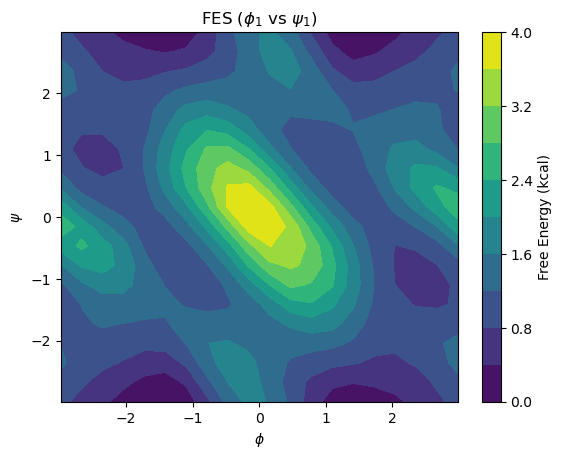

In [8]:
# Work with centers
x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

# Create a heatmap or 2D histogram plot
plt.contourf(x_centers, y_centers, hist.T, levels=9, cmap='viridis')
plt.colorbar(label='Free Energy (kcal)')
plt.xlabel('$\phi$')
plt.ylabel('$\psi$')
plt.title('FES ($\phi_1$ vs $\psi_1$)')
plt.show()